In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
import os

from codecarbon import EmissionsTracker

from utils.models import SimpleMLP, SimpleCNN, CVAE_MLP, CVAE_CNN

from utils.basics import get_impact_task, get_impact_tracker, \
    experiment_classif_simple, train_cvae, generate_digit_cvae, \
    plot_examples_classification, plot_wrong_classification, \
    plot_loss_acc_over_epochs, plot_co2_energy_over_epochs, \
    train_PCA, generate_digit_pca, \
    train_proba_pixel, generate_digit_proba_pixel

# Suppress specific FutureWarning from pandas
import warnings
warnings.filterwarnings(
    "ignore",
    message="The behavior of DataFrame concatenation with empty or all-NA entries is deprecated",
    category=FutureWarning
)

os.makedirs('.emissions_logs/', exist_ok=True)

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
device = 'cpu'
print(f"Using device: {device}")

Using device: cpu


# Basic operations

## First examples

In [2]:
tracker_first_example = EmissionsTracker(save_to_file=False)
tracker_first_example.start()

try:
    _ = 1 + 1 # Replace with code to track
finally:
    emissions_first_example = tracker_first_example.stop()
    print(f"Emissions: {emissions_first_example} kg CO2eq")

[codecarbon WARNING @ 14:49:46] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 14:49:46] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon INFO @ 14:49:46] [setup] RAM Tracking...
[codecarbon INFO @ 14:49:46] [setup] CPU Tracking...
[codecarbon WARNING @ 14:49:46] We saw that you have a Apple M4 Pro but we don't know it. Please contact us.
[codecarbon WARNING @ 14:49:46] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS detected: Please install Intel Power Gadget or enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 14:49:46] CPU Model on constant consumption mode: Apple M4 Pro
[codecarbon WARNING @ 14:49:46] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:49:46] [setup] GPU Tracking...
[codecarbon INFO @ 14:49:46] No GPU found.
[codecarbon INFO @ 14:49:46] The below tracking methods have been 

Emissions: 7.353356935372318e-10 kg CO2eq


## Increase the number of operations

[codecarbon WARNING @ 14:49:46] Multiple instances of codecarbon are allowed to run at the same time.


Emissions for        1 loops: 1.792776465304067e-10 kg CO2eq
Emissions for        3 loops: 1.9971527474195077e-10 kg CO2eq
Emissions for       10 loops: 1.5930112218920844e-10 kg CO2eq
Emissions for       31 loops: 1.8866901831329522e-10 kg CO2eq
Emissions for      100 loops: 1.80761245229579e-10 kg CO2eq
Emissions for      316 loops: 2.5883634439132753e-10 kg CO2eq
Emissions for     1000 loops: 2.2638501309411368e-10 kg CO2eq
Emissions for     3162 loops: 2.8080096543320303e-10 kg CO2eq
Emissions for    10000 loops: 4.385800601273918e-10 kg CO2eq
Emissions for    31622 loops: 1.1037722231405984e-09 kg CO2eq
Emissions for   100000 loops: 3.1131428504083956e-09 kg CO2eq
Emissions for   316227 loops: 6.347056670892506e-09 kg CO2eq
Emissions for  1000000 loops: 2.304381079959493e-08 kg CO2eq
Emissions for  3162277 loops: 6.002747281837931e-08 kg CO2eq
Emissions for 10000000 loops: 1.8144490793435768e-07 kg CO2eq


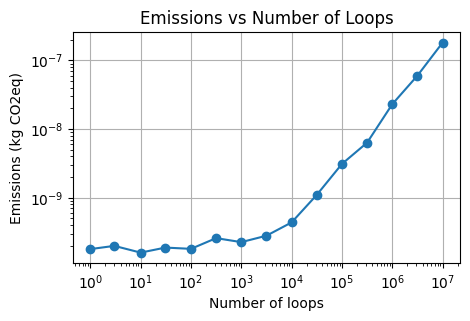

In [3]:
n_loops_tested = np.logspace(0, 7, num=15, dtype=int)
emissions_results = []

for n_loops in n_loops_tested:

    tracker = EmissionsTracker(project_name=f'Simple_loop_{n_loops}', log_level='error', 
                               output_dir='.emissions_logs', output_file='simple_loop.csv')
    tracker.start()

    try:
        for _ in range(n_loops):
            _ = 1 + 1
    finally:
        emissions = tracker.stop()
        emissions_results.append(emissions)
        print(f"Emissions for {n_loops:>8} loops: {emissions} kg CO2eq")

plt.figure(figsize=(5, 3))
plt.plot(n_loops_tested, emissions_results, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of loops')
plt.ylabel('Emissions (kg CO2eq)')
plt.title('Emissions vs Number of Loops')
plt.grid()
plt.show()

## Tasks

In [4]:
# Create an emissions tracker
tracker_test = EmissionsTracker(project_name='Test', log_level='error', 
                                output_dir='.emissions_logs', output_file='test.json')

# Start a new task
tracker_test.start_task(task_name="test1")
for _ in range(int(1e3)):
    _ = 1 + 1
emission_1 = tracker_test.stop_task()

# Start another task
tracker_test.start_task(task_name="test2")
for _ in range(int(1e6)):
    _ = 1 + 1
emission_2 = tracker_test.stop_task()

# Stop the tracker
emissions_test = tracker_test.stop()

# Print impact results
print("----- Impact test 1: -----")
impact1 = get_impact_task(emission_1, verbose=True)
print("\n----- Impact test 2: -----")
impact2 = get_impact_task(emission_2, verbose=True)
print("\n----- Impact tracker total: -----")
impact_tracker = get_impact_tracker(tracker_test, verbose=True)

----- Impact test 1: -----
emissions_kgCO2eq: 9.294628041391846e-10
total_energy_kWh: 1.6585999110247942e-08
cpu_energy_kWh: 1.4611345735223344e-08
gpu_energy_kWh: 0.0
ram_energy_kWh: 1.974653375024597e-09
cpu_power_W: 42.5
gpu_power_W: 0.0
ram_power_W: 6.0
water_L: 0.0

----- Impact test 2: -----
emissions_kgCO2eq: 2.416310318581689e-08
total_energy_kWh: 4.3118369681501964e-07
cpu_energy_kWh: 3.7792092027504826e-07
gpu_energy_kWh: 0.0
ram_energy_kWh: 5.3262776539971434e-08
cpu_power_W: 42.5
gpu_power_W: 0.0
ram_power_W: 6.0
water_L: 0.0

----- Impact tracker total: -----
total_emissions_kgCO2eq: 2.573969469621273e-08
total_energy_kWh: 4.5931752344282965e-07
total_cpu_energy_kWh: 4.0268405185391507e-07
total_gpu_energy_kWh: 0.0
total_ram_energy_kWh: 5.66334715889146e-08
cpu_power_W: 42.5
gpu_power_W: 0.0
ram_power_W: 6.0
total_water_L: 0.0
cpu_model: Apple M4 Pro
gpu_model: None
ram_total_size: 48.0


# Setup MNIST Experiment

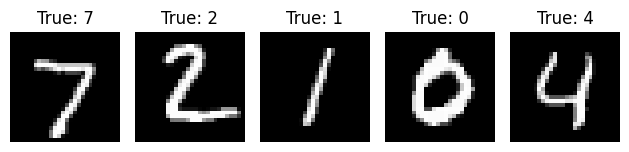

In [5]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Plot examples of digits (with true labels)
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
fig = plt.figure()
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(example_data[i].cpu().squeeze(), cmap='gray')
    plt.title(f"True: {example_targets[i].item()}")
    plt.axis("off")
plt.tight_layout()

# Classification tasks

## Expe - Simple MLP

In [6]:
hidden_dims_tested = [
    [32, 16], 
    [64, 32],
    [128, 64, 32],
    [256, 128, 64]
]

all_res_epochs_mlp = []
all_summaries_mlp = []
all_models_mlp = []
all_labels_mlp = []

for hidden_dims in hidden_dims_tested:
    print(f"> Training SimpleMLP with hidden dimensions: {hidden_dims}")
    
    label = f"SimpleMLP_{'_'.join(map(str, hidden_dims))}"
    folder_path = f'checkpoints/{str(device)}-{label}/'
    
    # If the log already exists, skip training and load the model
    if os.path.exists(f'{folder_path}res_epochs.json'):
        print(f"Skipping training {label} as log already exists.")
        # Load the model and results
        df_res_epochs = pd.read_json(f'{folder_path}res_epochs.json')
        with open(f'{folder_path}summary.json', 'r') as f:
            output_summary = json.load(f)
        model = SimpleMLP(hidden_dims=hidden_dims)
        model.load_state_dict(torch.load(f'{folder_path}model.pth', map_location=device))
    else:
        # Train the model
        model = SimpleMLP(hidden_dims=hidden_dims)
        df_res_epochs, output_summary = experiment_classif_simple(
            model, train_loader, test_loader,
            nbr_epochs=10, device=device, run_name=label,
            track_emissions=True
        )
        # Save the model and results
        os.makedirs(folder_path, exist_ok=True)
        df_res_epochs.to_json(f'{folder_path}res_epochs.json')
        with open(f'{folder_path}summary.json', 'w') as f:
            json.dump(output_summary, f)
        torch.save(model.state_dict(), f'{folder_path}model.pth')
    
    all_res_epochs_mlp.append(df_res_epochs)
    all_summaries_mlp.append(output_summary)
    all_models_mlp.append(model)
    all_labels_mlp.append(label)

> Training SimpleMLP with hidden dimensions: [32, 16]
Skipping training SimpleMLP_32_16 as log already exists.
> Training SimpleMLP with hidden dimensions: [64, 32]
Skipping training SimpleMLP_64_32 as log already exists.
> Training SimpleMLP with hidden dimensions: [128, 64, 32]
Skipping training SimpleMLP_128_64_32 as log already exists.
> Training SimpleMLP with hidden dimensions: [256, 128, 64]
Skipping training SimpleMLP_256_128_64 as log already exists.


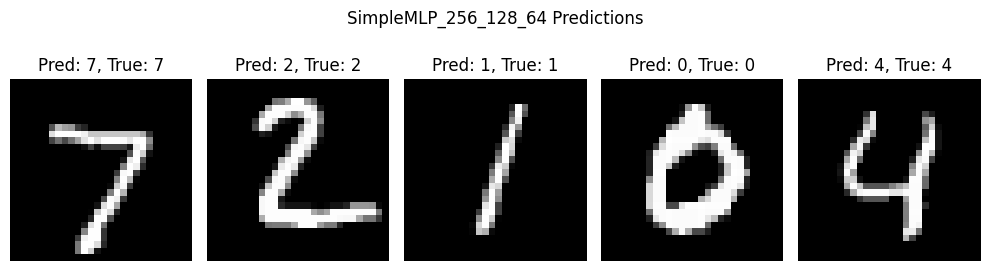

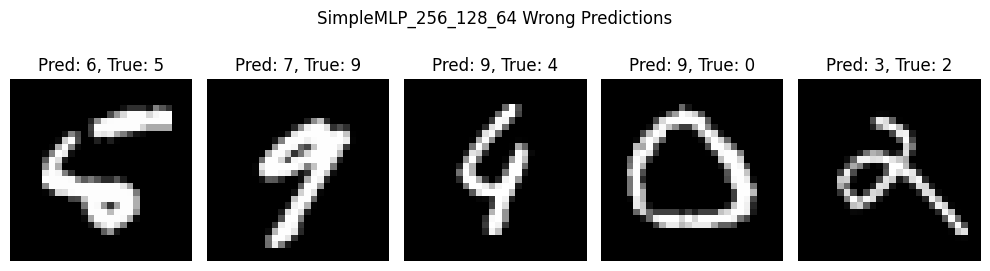

In [7]:
# Example of prediction
idx_model = -1  # Last trained model
plot_examples_classification(all_models_mlp[idx_model], test_loader, device, 
                             n=5, suptitle=all_labels_mlp[idx_model] + " Predictions")
plot_wrong_classification(all_models_mlp[idx_model], test_loader, device, 
                          n=5, suptitle=all_labels_mlp[idx_model] + " Wrong Predictions")

## Expe - Simple CNN

In [8]:
hidden_channels_tested = [
    [8], 
    [32],
    [32, 32],
    [64, 64, 64]
]

all_res_epochs_cnn = []
all_summaries_cnn = []
all_models_cnn = []
all_labels_cnn = []

for hidden_chans in hidden_channels_tested:
    print(f"> Training SimpleCNN with hidden channels: {hidden_chans}")
    
    label = f"SimpleCNN_{'_'.join(map(str, hidden_chans))}"
    folder_path = f'checkpoints/{str(device)}-{label}/'

    # If the log already exists, skip training and load the model
    if os.path.exists(f'{folder_path}res_epochs.json'):
        print(f"Skipping training {label} as log already exists.")
        df_res_epochs = pd.read_json(f'{folder_path}res_epochs.json')
        with open(f'{folder_path}summary.json', 'r') as f:
            output_summary = json.load(f)
        model = SimpleCNN(hidden_channels=hidden_chans)
        model.load_state_dict(torch.load(f'{folder_path}model.pth', map_location=device))
    # Train the model
    else:
        model = SimpleCNN(hidden_channels=hidden_chans)
        df_res_epochs, output_summary = experiment_classif_simple(
            model, train_loader, test_loader,
            nbr_epochs=10, device=device, run_name=label,
            track_emissions=True
        )
        os.makedirs(folder_path, exist_ok=True)
        df_res_epochs.to_json(f'{folder_path}res_epochs.json')
        with open(f'{folder_path}summary.json', 'w') as f:
            json.dump(output_summary, f)
        torch.save(model.state_dict(), f'{folder_path}model.pth')

    all_res_epochs_cnn.append(df_res_epochs)
    all_summaries_cnn.append(output_summary)
    all_models_cnn.append(model)
    all_labels_cnn.append(label)

> Training SimpleCNN with hidden channels: [8]
Skipping training SimpleCNN_8 as log already exists.
> Training SimpleCNN with hidden channels: [32]
Skipping training SimpleCNN_32 as log already exists.
> Training SimpleCNN with hidden channels: [32, 32]
Skipping training SimpleCNN_32_32 as log already exists.
> Training SimpleCNN with hidden channels: [64, 64, 64]
Skipping training SimpleCNN_64_64_64 as log already exists.


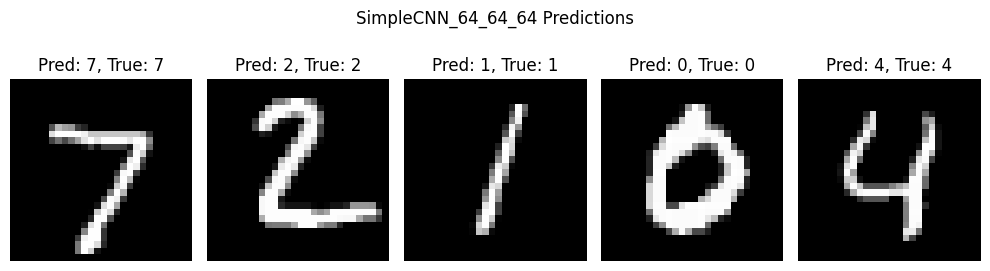

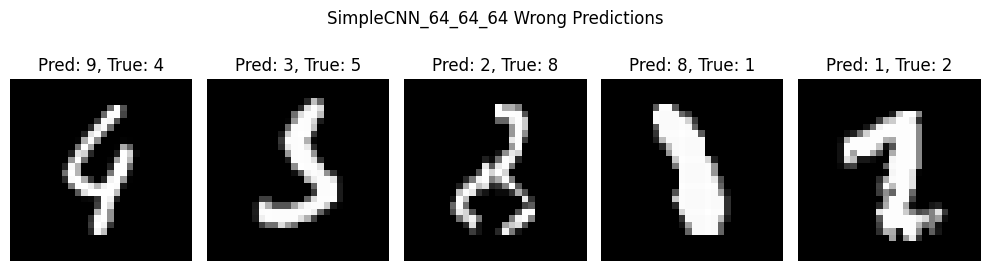

In [9]:
# Example of prediction
idx_model = -1  # Last trained model
plot_examples_classification(all_models_cnn[idx_model], test_loader, device, 
                             n=5, suptitle=all_labels_cnn[idx_model] + " Predictions")
plot_wrong_classification(all_models_cnn[idx_model], test_loader, device, 
                          n=5, suptitle=all_labels_cnn[idx_model] + " Wrong Predictions")

## Plots

In [10]:
# Combine summaries into a single DataFrame
summaries = pd.concat(
    [pd.DataFrame(all_summaries_mlp), pd.DataFrame(all_summaries_cnn)]
).reset_index(drop=True)

# Manage colors for pairplot
palette = {}
for i, name in enumerate(all_labels_mlp):
    palette[name] = sns.color_palette("autumn", len(all_labels_mlp)).pop(i)
for i, name in enumerate(all_labels_cnn):
    palette[name] = sns.color_palette("winter", len(all_labels_cnn)).pop(i)

### Summary

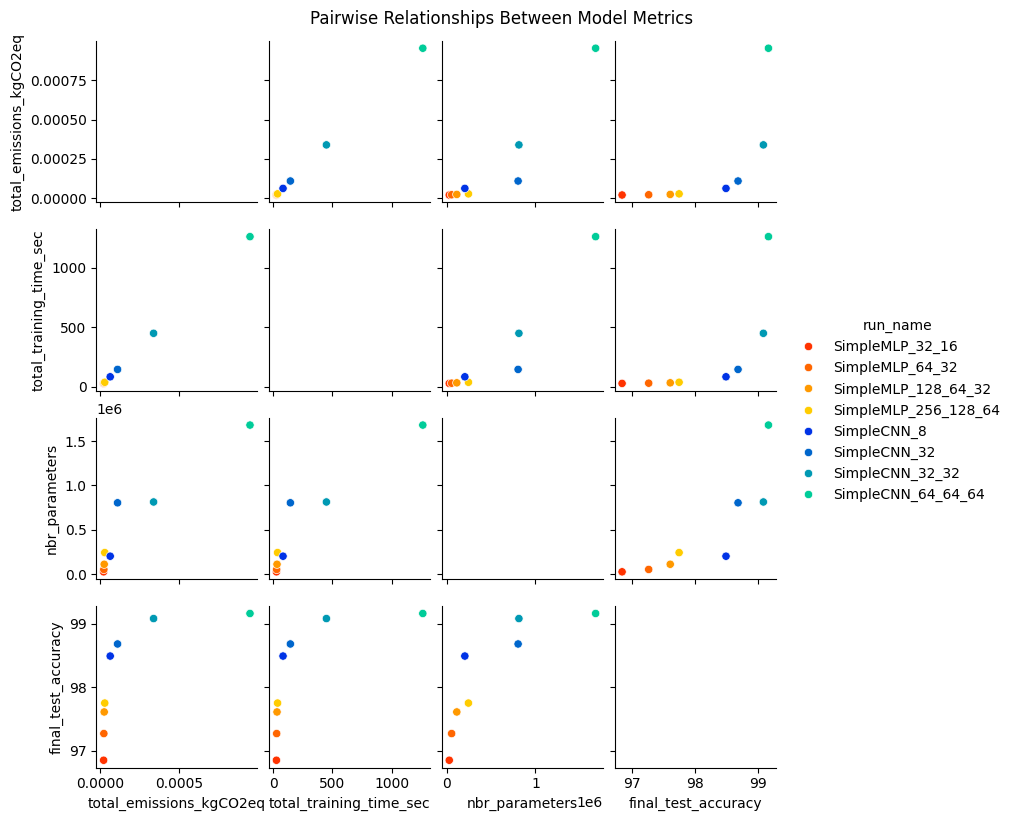

In [11]:
# Select columns to plot
cols_to_plot = [
    'total_emissions_kgCO2eq', 
    # 'total_energy_kWh', 
    'total_training_time_sec', 
    'nbr_parameters',
    'final_test_accuracy', 
    # 'final_train_loss',
]

# Pairplot of metrics
sns.pairplot(summaries[cols_to_plot + ['run_name']], hue="run_name", 
             diag_kind='', corner=False, height=2, palette=palette)
plt.suptitle("Pairwise Relationships Between Model Metrics", y=1.02)
plt.show()

### Over epochs

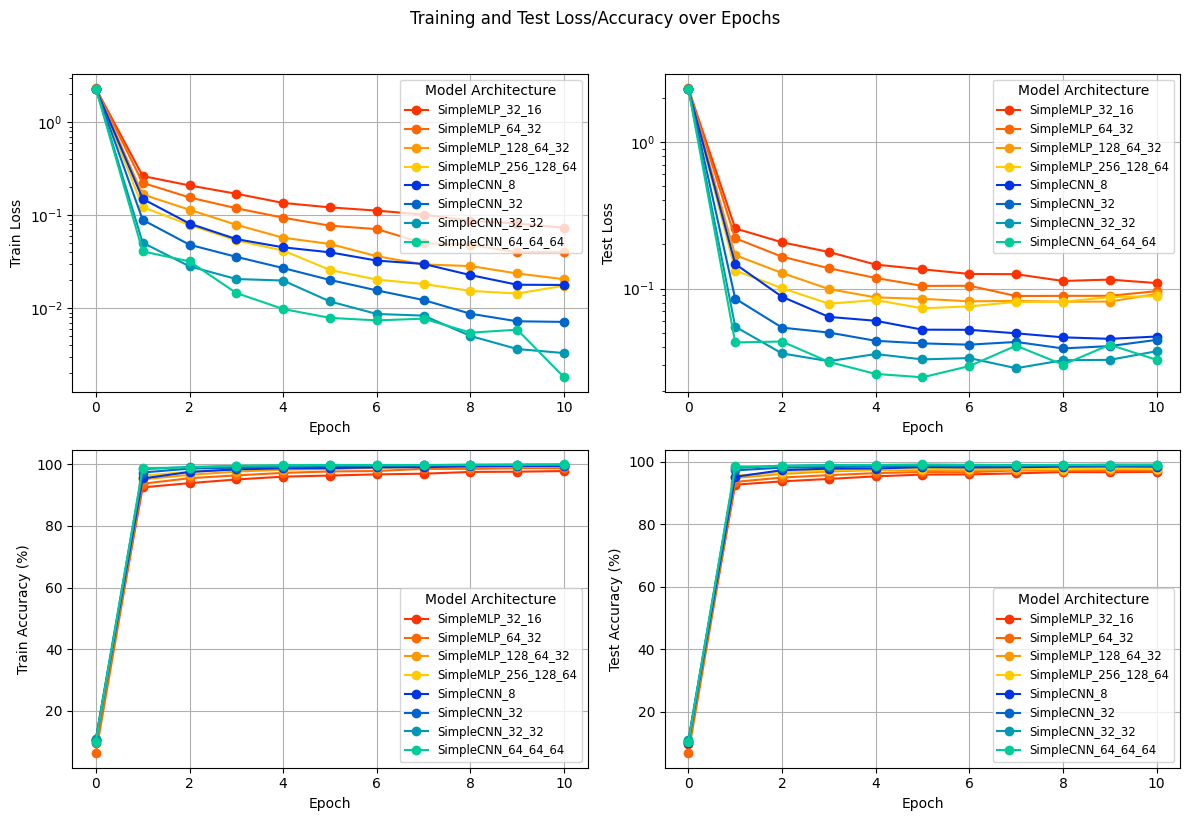

In [12]:
plot_loss_acc_over_epochs(
    all_res_epochs_mlp + all_res_epochs_cnn, 
    all_labels_mlp + all_labels_cnn, 
    palette
)

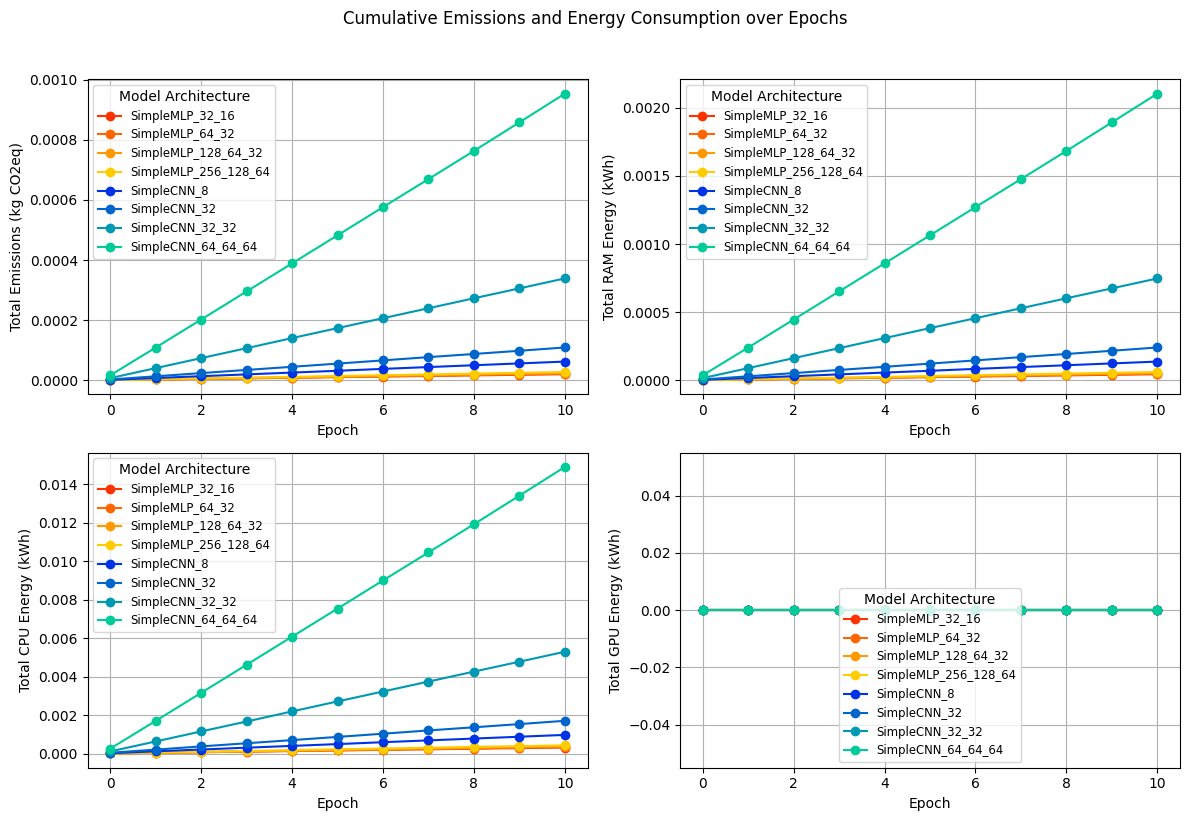

In [13]:
plot_co2_energy_over_epochs(
    all_res_epochs_mlp + all_res_epochs_cnn, 
    all_labels_mlp + all_labels_cnn, 
    palette
)

# Image generation tasks

## CVAE with MLP

In [14]:
hidden_dims = [400, 100]
latent_dim = 20

cvae_mlp = CVAE_MLP(hidden_dims=hidden_dims, latent_dim=latent_dim)

num_params = sum(p.numel() for p in cvae_mlp.parameters() if p.requires_grad)
print(f"CVAE_MLP number of parameters: {num_params}")

folder_path = f'checkpoints/{str(device)}-CVAE_MLP_{"_".join(map(str, hidden_dims))}_latent{latent_dim}/'

if os.path.exists(folder_path + 'model.pth'):
    print("Loading pre-trained CVAE_MLP model.")
    # Load model and results
    cvae_mlp.load_state_dict(
        torch.load(folder_path + 'model.pth', map_location=device)
    )
    with open(f'{folder_path}emission_train.json', 'r') as f:
        emission_train_cvae_mlp = json.load(f)
else:
    emission_train_cvae_mlp = train_cvae(
        cvae_mlp, train_loader, epochs=10, device=device, track_emissions=True
    )
    # Save model and results
    os.makedirs(folder_path, exist_ok=True)
    torch.save(cvae_mlp.state_dict(), f'{folder_path}model.pth')
    with open(f'{folder_path}emission_train.json', 'w') as f:
        json.dump(emission_train_cvae_mlp, f)

print("--------------------------------")
print("CVAE_MLP Training Emissions:")
for k, v in emission_train_cvae_mlp.items():
    if type(v) == float:
        message = f"{k}: {v:.3f}" if v >= 1e-2 else f"{k}: {v:.2e}"
    else:
        message = f"{k}: {v}"
    print(message)

CVAE_MLP number of parameters: 720024
Loading pre-trained CVAE_MLP model.
--------------------------------
CVAE_MLP Training Emissions:
total_emissions_kgCO2eq: 3.03e-05
total_energy_kWh: 5.41e-04
total_cpu_energy_kWh: 4.74e-04
total_gpu_energy_kWh: 0.00e+00
total_ram_energy_kWh: 6.69e-05
cpu_power_W: 42.500
gpu_power_W: 0.00e+00
ram_power_W: 6.000
total_water_L: 0.00e+00
cpu_model: Apple M4 Pro
gpu_model: None
ram_total_size: 48.000
total_training_time_sec: 40.136


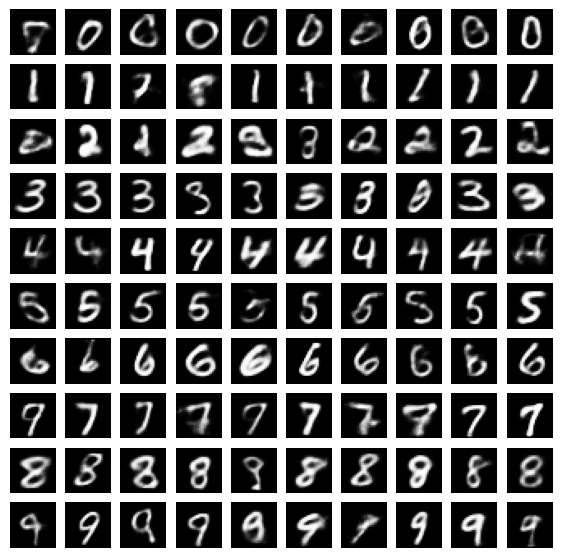

total_emissions_kgCO2eq: 6.51e-09
total_energy_kWh: 1.16e-07
total_cpu_energy_kWh: 1.02e-07
total_gpu_energy_kWh: 0.00e+00
total_ram_energy_kWh: 1.42e-08
cpu_power_W: 42.500
gpu_power_W: 0.00e+00
ram_power_W: 6.000
total_water_L: 0.00e+00
cpu_model: Apple M4 Pro
gpu_model: None
ram_total_size: 48.000


In [15]:
all_imgs_mlp, emission_gen_cvae_mlp = generate_digit_cvae(
    cvae_mlp, n_samples=10, device=device, track_emissions=True
)
for k, v in emission_gen_cvae_mlp.items():
    if isinstance(v, float):
        message = f"{k}: {v:.3f}" if v >= 1e-2 else f"{k}: {v:.2e}"
    else:
        message = f"{k}: {v}"
    print(message)

## CVAE with CNN

In [16]:
hidden_channels = [32, 64, 128]
latent_dim = 20

cvae_cnn = CVAE_CNN(hidden_channels=hidden_channels, latent_dim=latent_dim)

num_params = sum(p.numel() for p in cvae_cnn.parameters() if p.requires_grad)
print(f"CVAE_CNN number of parameters: {num_params}")

folder_path = f'checkpoints/{str(device)}-CVAE_CNN_{"_".join(map(str, hidden_channels))}_latent{latent_dim}/'

if os.path.exists(folder_path + 'model.pth'):
    print("Loading pre-trained CVAE_CNN model.")
    # Load model and results
    cvae_cnn.load_state_dict(
        torch.load(folder_path + 'model.pth', map_location=device)
    )
    with open(f'{folder_path}emission_train.json', 'r') as f:
        emission_train_cvae_cnn = json.load(f)
else:
    emission_train_cvae_cnn = train_cvae(
        cvae_cnn, train_loader, epochs=5, device=device, track_emissions=True
    )
    # Save model and results
    os.makedirs(folder_path, exist_ok=True)
    torch.save(cvae_cnn.state_dict(), f'{folder_path}model.pth')
    with open(f'{folder_path}emission_train.json', 'w') as f:
        json.dump(emission_train_cvae_cnn, f)

print("--------------------------------")
print("CVAE_CNN Training Emissions:")
for k, v in emission_train_cvae_cnn.items():
    if isinstance(v, float):
        message = f"{k}: {v:.3f}" if v >= 1e-2 else f"{k}: {v:.2e}"
    else:
        message = f"{k}: {v}"
    print(message)

CVAE_CNN number of parameters: 1969609
Loading pre-trained CVAE_CNN model.
--------------------------------
CVAE_CNN Training Emissions:
total_emissions_kgCO2eq: 4.78e-04
total_energy_kWh: 8.53e-03
total_cpu_energy_kWh: 7.47e-03
total_gpu_energy_kWh: 0.00e+00
total_ram_energy_kWh: 1.06e-03
cpu_power_W: 42.500
gpu_power_W: 0.00e+00
ram_power_W: 6.000
total_water_L: 0.00e+00
cpu_model: Apple M4 Pro
gpu_model: None
ram_total_size: 48.000
total_training_time_sec: 633.066


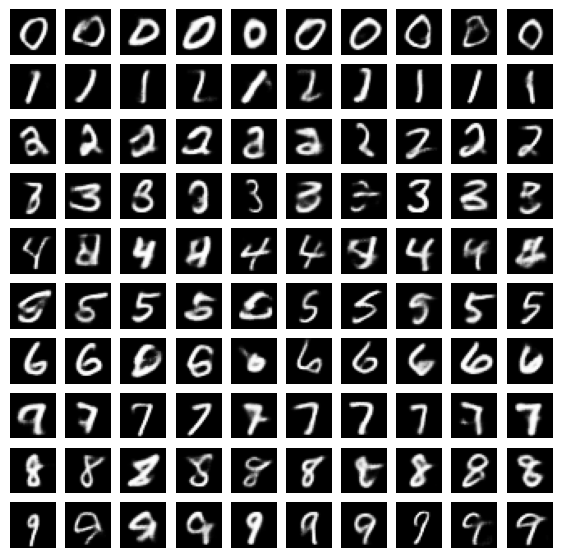

total_emissions_kgCO2eq: 2.13e-08
total_energy_kWh: 3.81e-07
total_cpu_energy_kWh: 3.34e-07
total_gpu_energy_kWh: 0.00e+00
total_ram_energy_kWh: 4.70e-08
cpu_power_W: 42.500
gpu_power_W: 0.00e+00
ram_power_W: 6.000
total_water_L: 0.00e+00
cpu_model: Apple M4 Pro
gpu_model: None
ram_total_size: 48.000


In [17]:
all_imgs_cnn, emission_gen_cvae_cnn = generate_digit_cvae(
    cvae_cnn, n_samples=10, device=device, track_emissions=True
)
for k, v in emission_gen_cvae_cnn.items():
    if isinstance(v, float):
        message = f"{k}: {v:.3f}" if v >= 1e-2 else f"{k}: {v:.2e}"
    else:
        message = f"{k}: {v}"
    print(message)

## PCA

In [18]:
# Flatten MNIST images
X_train = train_dataset.data.numpy().reshape(-1, 28*28)
y_train = train_dataset.targets.numpy()

PCA Training Emissions (kgCO2eq): 4.15e-07


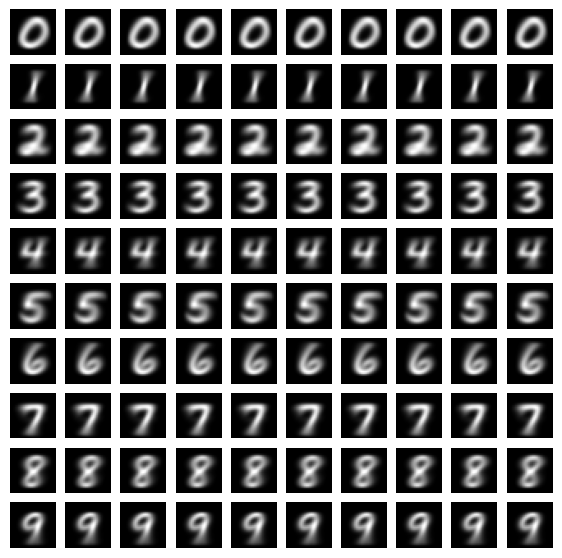

PCA Generation Emissions (kgCO2eq): 8.89e-10


In [19]:
all_pcas, emission_train_PCA = train_PCA(X_train, y_train, n_components=50, track_emissions=True)
print(f"PCA Training Emissions (kgCO2eq): {emission_train_PCA['total_emissions_kgCO2eq']:.2e}")

all_imgs, emission_info = generate_digit_pca(all_pcas, n_samples=10, track_emissions=True)
print(f"PCA Generation Emissions (kgCO2eq): {emission_info['total_emissions_kgCO2eq']:.2e}")

Probabilistic Pixel Training Emissions (kgCO2eq): 3.65e-08


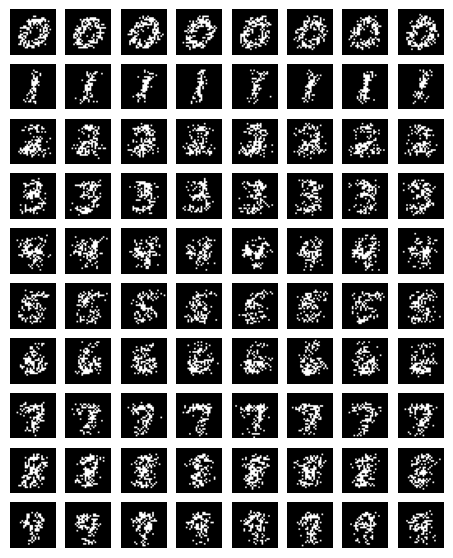

Probabilistic Pixel Generation Emissions (kgCO2eq): 1.94e-09


In [20]:
all_p, emission_info = train_proba_pixel(X_train, y_train, track_emissions=True)
print(f"Probabilistic Pixel Training Emissions (kgCO2eq): "
      f"{emission_info['total_emissions_kgCO2eq']:.2e}")

all_imgs, emission_info = generate_digit_proba_pixel(all_p, n_samples=8, track_emissions=True)
print(f"Probabilistic Pixel Generation Emissions (kgCO2eq): "
      f"{emission_info['total_emissions_kgCO2eq']:.2e}")

# Text generation tasks

In [21]:
from transformers import BertTokenizer, BertForMaskedLM

# Load pretrained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForMaskedLM.from_pretrained("bert-base-uncased").to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"BERT number of parameters: {num_params}")

model.eval()

# Example: mask a word
text_examples = [
    "The capital of France is [MASK].",
    "The largest planet in our solar system is [MASK].",
    "The most passionate programming language is [MASK]."
]

for text in text_examples:

    tracker_bert = EmissionsTracker(save_to_file=False, log_level='error')
    tracker_bert.start()
    
    inputs = tokenizer(text, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        predictions = outputs.logits

    # Get the token id with the highest probability at the masked position
    mask_token_index = (inputs.input_ids == tokenizer.mask_token_id)[0].nonzero(as_tuple=True)[0]
    predicted_token_id = predictions[0, mask_token_index, :].argmax(dim=-1)
    
    top_k = 5
    top_k_token_ids = predictions[0, mask_token_index, :].topk(top_k).indices
    top_k_token_probs = predictions[0, mask_token_index, :].topk(top_k).values
    str_top_k = [f"{tokenizer.decode([token_id])} ({prob.item():.1f})" for token_id, prob in zip(top_k_token_ids[0], top_k_token_probs[0])]

    predicted_token = tokenizer.decode(predicted_token_id)
    
    emission_bert = tracker_bert.stop()
    print("\n--------------------------------\n")
    print(f"Original text: {text}")
    print(f"Predicted token (top {top_k}): {str_top_k}")
    print(f"Filled sentence: {text.replace(tokenizer.mask_token, predicted_token)}")
    print(f"\n  > BERT Prediction Emissions: {emission_bert:.2e} kg CO2eq")


/Users/raphael_benerradi/Documents/Thèse/LIRMM/01-MCE/2025-2026 Polytech/Cours IA et environnement/AI-Impacts-lab_session/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification m

BERT number of parameters: 109514298

--------------------------------

Original text: The capital of France is [MASK].
Predicted token (top 5): ['paris (12.3)', 'lille (10.6)', 'lyon (10.5)', 'marseille (10.1)', 'tours (9.7)']
Filled sentence: The capital of France is paris.

  > BERT Prediction Emissions: 7.05e-07 kg CO2eq

--------------------------------

Original text: The largest planet in our solar system is [MASK].
Predicted token (top 5): ['earth (10.3)', 'pluto (10.2)', 'jupiter (9.9)', 'mars (9.9)', 'saturn (9.3)']
Filled sentence: The largest planet in our solar system is earth.

  > BERT Prediction Emissions: 3.43e-08 kg CO2eq

--------------------------------

Original text: The most passionate programming language is [MASK].
Predicted token (top 5): ['java (10.5)', 'python (9.9)', 'c (9.8)', 'english (9.0)', 'php (7.4)']
Filled sentence: The most passionate programming language is java.

  > BERT Prediction Emissions: 4.08e-08 kg CO2eq


In [22]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Load GPT-2 tokenizer and model
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)

num_params = sum(p.numel() for p in gpt2_model.parameters() if p.requires_grad)
print(f"GPT-2 number of parameters: {num_params}")

gpt2_model.eval()

# Example prompt
prompt_examples = [
    "Once upon a time in a galaxy far, far away",
    "In the future, artificial intelligence will",
    "The secret to a happy life is"
]

for prompt in prompt_examples:

    tracker_gpt2 = EmissionsTracker(save_to_file=False, log_level='error')
    tracker_gpt2.start()

    inputs = gpt2_tokenizer(prompt, return_tensors="pt").to(device)
    attention_mask = inputs["attention_mask"]

    # Generate text
    with torch.no_grad():
        output_ids = gpt2_model.generate(
            inputs["input_ids"],
            attention_mask=attention_mask,
            max_length=200,
            num_return_sequences=1,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            pad_token_id=gpt2_tokenizer.eos_token_id
        )

    generated_text = gpt2_tokenizer.decode(output_ids[0], skip_special_tokens=True)
    
    emission_gpt2 = tracker_gpt2.stop()
    print("\n--------------------------------\n")
    print("Prompt:", prompt)
    print(f"Generated ({len(output_ids[0])} tokens):", generated_text)
    print(f"\n  > GPT-2 Prediction Emissions: {emission_gpt2:.2e} kg CO2eq")


GPT-2 number of parameters: 124439808

--------------------------------

Prompt: Once upon a time in a galaxy far, far away
Generated (200 tokens): Once upon a time in a galaxy far, far away, the planet is home to a sentient race of sentient race called the Mavivians. Their civilization is a hive mind controlled by an extraterrestrial race known as the Mavivians who can manipulate all forms of matter and energy in their favor. The Mavivians' vast intellect allows them to design everything in a given instant, using their advanced technology to accomplish this very task.

The Mavivians' own primary technology is the Ion Drive, which uses powerful weapons known as the Ion Cannon to project immense energy at one moment and send all known matter and energy in a certain direction. In order to accomplish this, the Mavivians use a combination of weapons that the Mavivians have learned to master. After they learn the power of the Ion Drive, the Mavivians are able to use it to make a weapon for 